In [288]:
import Random#, logging
using  Plots, CSV, Gen#, Dates
using DataFrames: DataFrame
# Disable logging, because @animate is verbose otherwise
#Logging.disable_logging(Logging.Info);

In [289]:
SubChunkSize = 20
@gen function regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    Indx::Int64 = 1
    Buffer_x::Float64 = 0
    Buffer_y::Float64 = 0
    TrueMu::Float64 = 0
    prob_outlier = {:prob_outlier} ~ uniform(0, .2)
    for i = 1:NumChunks
        slope = {(:slope, i)} ~ normal(0, 300)
        SubSlope = {(:SubSlope, i)} ~ normal(0, 300)
        noise = {(:noise, i)} ~ gamma(200, 200)
        # Next, we generate the actual y coordinates.
         ys = Float64[]
        for j = 1:SubChunkSize
            # Decide whether this point is an outlier, and set
            # mean and standard deviation accordingly
            if Indx <= n
                if !(Indx + 1 > n)
                    offSetX = xs[Indx] - Buffer_x
                else
                    offSetX = 0
                end
                TrueMu = slope * ((offSetX)^2) + SubSlope * offSetX + Buffer_y
                if ({:data => Indx => :is_outlier} ~ bernoulli(prob_outlier))
                    (mu, std) = (3 * TrueMu,  noise)
                else
                    (mu, std) = (TrueMu,  noise)
                end
                # Sample a y value for this point
                push!(ys, {:data => Indx => :y} ~ normal((mu), std))
                Indx += 1
            end
        end
        if Indx <= n
            Buffer_y = TrueMu
            Buffer_x = xs[Indx]
        end
    end 
    ys
end;

In [290]:
using Plots
#length(floor(xs/40)+1)
function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    Dict(:slope => [trace[(:slope, i)] for i in 1:NumChunks],
         :SubSlope => [trace[(:SubSlope, i)] for i in 1:NumChunks],
         :inlier_std => [trace[(:noise, i)] for i in 1:NumChunks],
         :points => zip(xs, [trace[:data => i => :y] for i in 1:length(xs)]),
         :xs => xs,
         :outliers => [trace[:data => i => :is_outlier] for i in 1:length(xs)])
end

serialize_trace (generic function with 1 method)

In [291]:
function visualize_trace(trace::Trace; title="")
    trace = serialize_trace(trace)
    n = length(trace[:xs])
    NumChunks = div(n, SubChunkSize, RoundUp)
    outliers = [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if outlier]
    inliers =  [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if !outlier]
    PLT = Plots.scatter(map(first, inliers), map(last, inliers), markercolor="blue", label=nothing, title=title) 
    PLT = Plots.scatter!(map(first, outliers), map(last, outliers), markercolor="red", label=nothing)
    Buffer_y::Float64 = 0
    Buffer_x::Float64 = 0
    left_x::Float64 = 0
    left_y::Float64 = 0
    right_y::Float64 = 0
    right_x::Float64 = 0
    for i = 1:NumChunks
        inferred_line(x) = (trace[:slope][i] * ((x - Buffer_x)^2)) + (trace[:SubSlope][i] * (x - Buffer_x)) + Buffer_y
        for j = 1:SubChunkSize
            if(SubChunkSize*(i-1)+j > n)
                right_x = trace[:xs][n]
            else
                right_x = trace[:xs][SubChunkSize*(i-1)+j]
            end
            right_y = inferred_line(right_x)
            PLT = Plots.plot!([left_x, right_x], [left_y, right_y], color = "black", lw = 3, label = nothing)
            left_x = right_x
            left_y = right_y
        end
        Buffer_y = right_y
        Buffer_x = right_x
    end
    return PLT
end
#, xlims=[MinX, MaxX], ylims=[MinY, MaxY]

visualize_trace (generic function with 1 method)

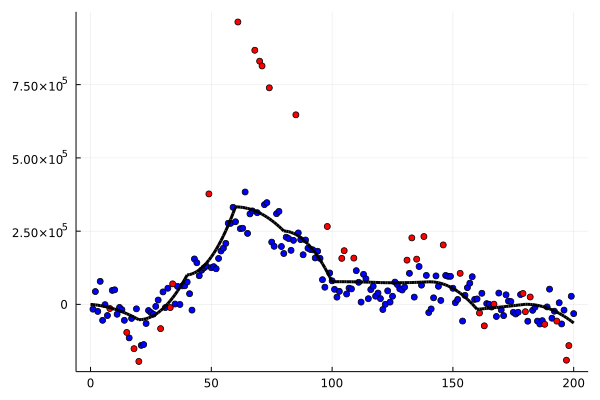

In [292]:
xs     = collect(range(1, stop=200, length=200))
traces = Gen.simulate(regression_with_outliers, (xs,));
Plots.plot(visualize_trace(traces))

In [293]:
dataframe = CSV.read("../Data/Proccesed/DetrendedCov.csv", DataFrame)

,Column1,Date,N1,LoessN1,DetrendedN1
,Int64,Int64,Int64,Float64,Float64
1,1,0,63618,-3628.0,67246.0
2,2,4,11442,12206.4,-764.409
3,3,7,39145,24029.8,15115.2
4,4,10,28553,35819.2,-7266.18
5,5,9,16743,31895.1,-15152.1
6,6,8,30509,27971.0,2538.04
7,7,13,22794,47527.4,-24733.4
8,8,14,25014,51430.1,-26416.1
9,9,17,38687,63050.0,-24363.0


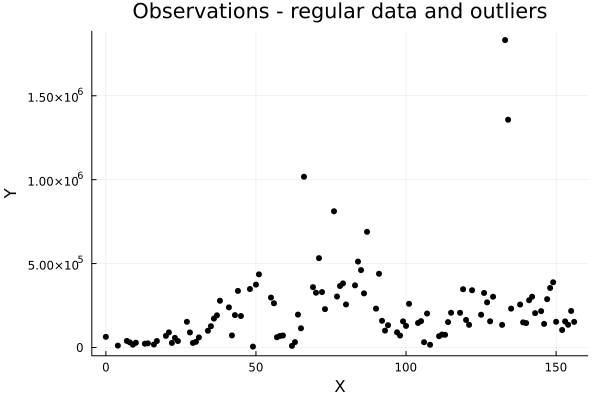

In [294]:
#using DataArrays
dataframe[!,:N1] = convert.(Base.Float64,dataframe[!,:N1])
dataframe[!,:Date] = convert.(Base.Float64,dataframe[!,:Date])
#390
xs = dataframe."Date"[1:390]
ys = dataframe."N1"[1:390]

Plots.scatter(xs, ys, color="black", xlabel="X", ylabel="Y", 
              label=nothing, title="Observations - regular data and outliers")

In [295]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

In [296]:
observations = make_constraints(ys);

In [297]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

In [298]:
#traces    = [first(Gen.importance_resampling(regression_with_outliers, (xs,), observations, 1000)) for i in 1:9]
#log_probs = [get_score(t) for t in traces]
#println("Average log probability: $(logmeanexp(log_probs))")
#Plots.plot([visualize_trace(t) for t in traces]...)

In [299]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    (xs,) = get_args(tr)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    for j=1:NumChunks
        # Block 1: Update the line's parameters
        line_params = select((:noise,j), (:slope,j), (:intercept,j), (:SubSlope,j))
        (tr, _) = mh(tr, line_params)
    end
    
    # Blocks 2-N+1: Update the outlier classifications
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

In [300]:
function block_resimulation_inference(xs, ys)
    observations = make_constraints(ys)
    (tr, W) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:100
        tr = block_resimulation_update(tr)
    end
    tr
end;

Plots.AnimatedGif("C:\\Users\\marli\\AppData\\Local\\Temp\\jl_MeceJuPR3r.gif")
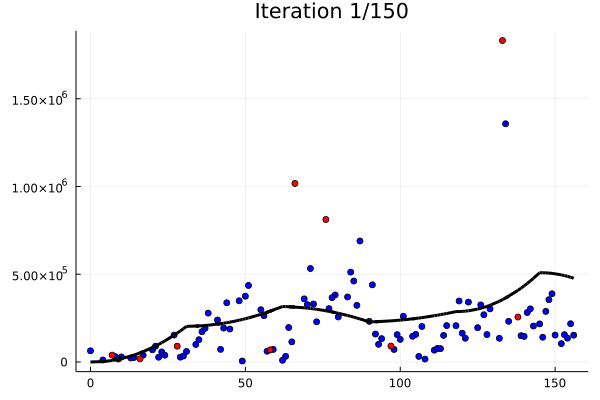

In [301]:
t, = generate(regression_with_outliers, (xs,), observations)
Iter = 150
viz = Plots.@animate for i in 1:Iter
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/$Iter")
end;
gif(viz)